In [6]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
#from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import EfficientNetB0
import cv2
import random
import math

# Suppress TensorFlow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
print(f"Using TensorFlow version: {tf.__version__}")


Using TensorFlow version: 2.15.0


In [9]:

video_folder = r'videos'
category = 'coe'
base_output_folder = 'dataset'
total_frames_to_extract = 350

train_folder = os.path.join(base_output_folder, 'training', category)
test_folder = os.path.join(base_output_folder, 'testing', category)
val_folder = os.path.join(base_output_folder, 'validation', category)

os.makedirs(train_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)
os.makedirs(val_folder, exist_ok=True)

# Step 1: Gather all (video_file, frame_idx) pairs
all_frames = []
for video_file in os.listdir(video_folder):
    if not video_file.lower().endswith(('.mp4', '.avi', '.mov', '.mkv')):
        continue
    video_path = os.path.join(video_folder, video_file)
    cap = cv2.VideoCapture(video_path)
    frame_idx = 0
    while True:
        ret, _ = cap.read()
        if not ret:
            break
        all_frames.append((video_file, frame_idx))
        frame_idx += 1
    cap.release()

# Step 2: Randomly select 500 frames
random.shuffle(all_frames)
selected_frames = all_frames[:total_frames_to_extract]

# Step 3: Assign splits
n_train = int(total_frames_to_extract * 0.7)
n_test = int(total_frames_to_extract * 0.15)
n_val = total_frames_to_extract - n_train - n_test

split_frames = (
    ('train', selected_frames[:n_train]),
    ('test', selected_frames[n_train:n_train+n_test]),
    ('val', selected_frames[n_train+n_test:])
)

# Step 4: Extract and save the selected frames
for split, frames in split_frames:
    for video_file, frame_idx in frames:
        video_path = os.path.join(video_folder, video_file)
        cap = cv2.VideoCapture(video_path)
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
        ret, frame = cap.read()
        cap.release()
        if not ret:
            continue
        if split == 'train':
            target_folder = train_folder
        elif split == 'test':
            target_folder = test_folder
        else:
            target_folder = val_folder
        frame_filename = os.path.join(
            target_folder, f'{os.path.splitext(video_file)[0]}_frame_{frame_idx:05d}.jpg'
        )
        cv2.imwrite(frame_filename, frame)

print(f"Extracted {n_train} frames to training, {n_test} to testing, {n_val} to validation.")

Extracted 244 frames to training, 52 to testing, 54 to validation.


In [ ]:
# Classes
classes = ['admin', 'ansci', 'coe', 'dcst', 'dss', 'dthm', 'foodtech', 'forestry', 'gym']

# Arrays to hold images and labels
X_train, Z_train = [], []
X_val, Z_val = [], []
X_test, Z_test = [], []

def assign_label(building_type):
    building_type = building_type.lower()
    if building_type in classes:
        return classes.index(building_type)
    else:
        print(f"Warning: Unrecognized building type: {building_type}")
        return None

# Dataset path
project_dir = os.getcwd()
inputdataset = os.path.join(project_dir, "dataset")

# Load images
def load_images_from_folder(folder_path, X, Z):
    for building in os.listdir(folder_path):
        building_path = os.path.join(folder_path, building)
        if not os.path.isdir(building_path):
            continue
        label = assign_label(building)
        if label is None:
            continue
        for filename in os.listdir(building_path):
            img_path = os.path.join(building_path, filename)
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)
            if img is None:
                continue
            img = cv2.resize(img, (224,224))
            img = img / 255.0
            X.append(img)
            Z.append(label)

# Load datasets
load_images_from_folder(os.path.join(inputdataset, 'training'), X_train, Z_train)
load_images_from_folder(os.path.join(inputdataset, 'validation'), X_val, Z_val)
load_images_from_folder(os.path.join(inputdataset, 'testing'), X_test, Z_test)

# Convert to numpy arrays
X_train, Z_train = np.array(X_train), np.array(Z_train)
X_val, Z_val = np.array(X_val), np.array(Z_val)
X_test, Z_test = np.array(X_test), np.array(Z_test)

# One-hot encoding
Y_train = to_categorical(Z_train, len(classes))
Y_val = to_categorical(Z_val, len(classes))
Y_test = to_categorical(Z_test, len(classes))

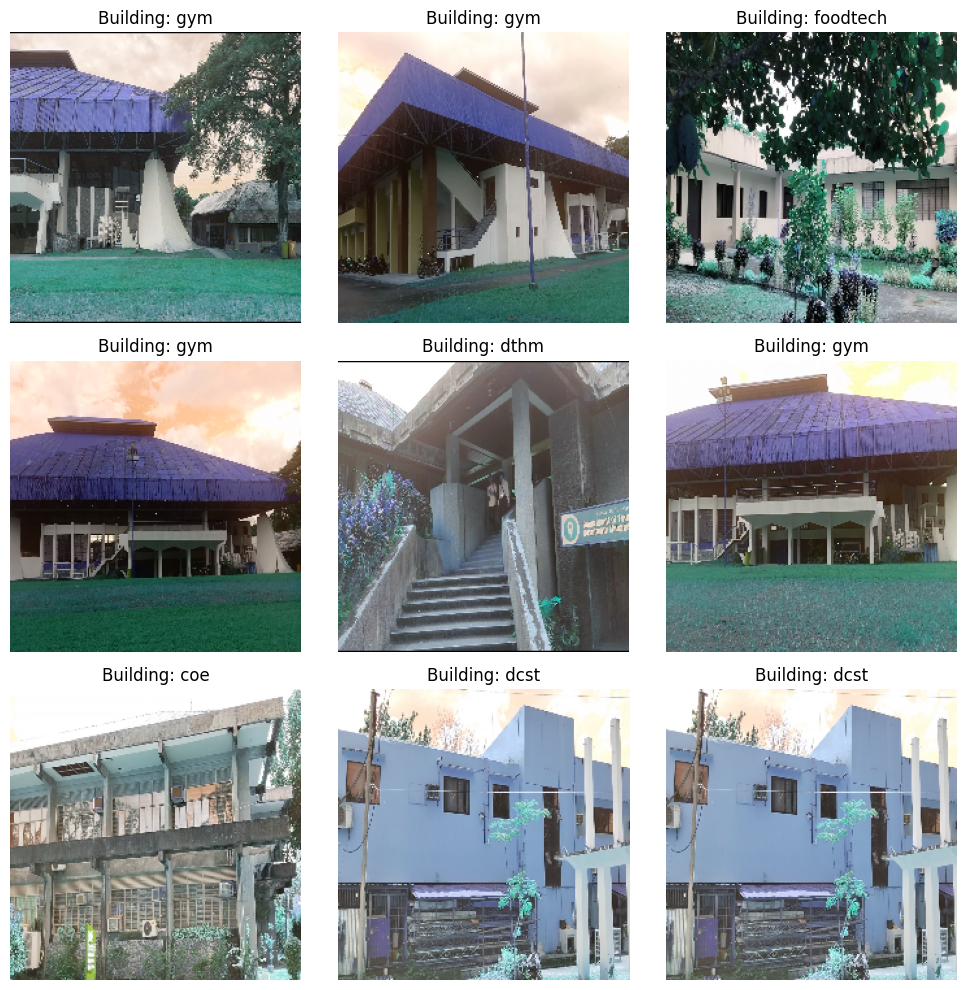

In [ ]:
# Visualize random training samples
figure, axes = plt.subplots(3, 3)
figure.set_size_inches(10, 10)
for row in range(3):
    for col in range(3):
        index = random.randint(0, len(X_train) - 1)
        image = X_train[index]
        building_label = Z_train[index]
        axes[row, col].imshow(image)
        axes[row, col].set_title(f"Building: {classes[building_label]}")
        axes[row, col].axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# ✅ Load MobileNetV2 as base model
#base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150,150,3))
#base_model.trainable = False  # Freeze base layers

# effecient net as base model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model.trainable = False  # Freeze base layers

#mobilenet model
# Add custom top layers
#x = base_model.output
#x = GlobalAveragePooling2D()(x)
#x = Dense(128, activation='relu')(x)
#x = Dropout(0.5)(x)
#output = Dense(len(classes), activation='softmax')(x)



# Add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(len(classes), activation='softmax')(x)

# Final model
model = Model(inputs=base_model.input, outputs=output)

# Summary
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_2 (Rescaling)     (None, 224, 224, 3)          0         ['input_2[0][0]']             
                                                                                                  
 normalization_1 (Normaliza  (None, 224, 224, 3)          7         ['rescaling_2[0][0]']         
 tion)                                                                                            
                                                                                                  
 rescaling_3 (Rescaling)     (None, 224, 224, 3)          0         ['normalization_1[0][0]'

In [ ]:
# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# ✅ Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(filepath='best_model_effecientnetb0.keras', save_best_only=True, monitor='val_loss')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, min_lr=1e-6)


In [ ]:
# ✅ Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Fit the model
history = model.fit(
    datagen.flow(X_train, Y_train, batch_size=32),
    epochs=40,
    validation_data=(X_val, Y_val),
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

Epoch 1/40
57/57 [==============================] - 111s 1s/step - loss: 2.1961 - accuracy: 0.1005 - val_loss: 2.1974 - val_accuracy: 0.1114 - lr: 0.0010
Epoch 2/40
57/57 [==============================] - 71s 1s/step - loss: 2.1955 - accuracy: 0.1094 - val_loss: 2.1975 - val_accuracy: 0.1114 - lr: 0.0010
Epoch 3/40
57/57 [==============================] - 67s 1s/step - loss: 2.1950 - accuracy: 0.1005 - val_loss: 2.1977 - val_accuracy: 0.1114 - lr: 0.0010
Epoch 4/40
57/57 [==============================] - 63s 1s/step - loss: 2.1945 - accuracy: 0.1166 - val_loss: 2.1980 - val_accuracy: 0.1114 - lr: 0.0010
Epoch 5/40
57/57 [==============================] - 69s 1s/step - loss: 2.1942 - accuracy: 0.0938 - val_loss: 2.1982 - val_accuracy: 0.1114 - lr: 0.0010
Epoch 6/40
57/57 [==============================] - 64s 1s/step - loss: 2.1939 - accuracy: 0.1138 - val_loss: 2.1982 - val_accuracy: 0.1114 - lr: 2.0000e-04
Epoch 7/40
57/57 [==============================] - 61s 1s/step - loss: 2.193

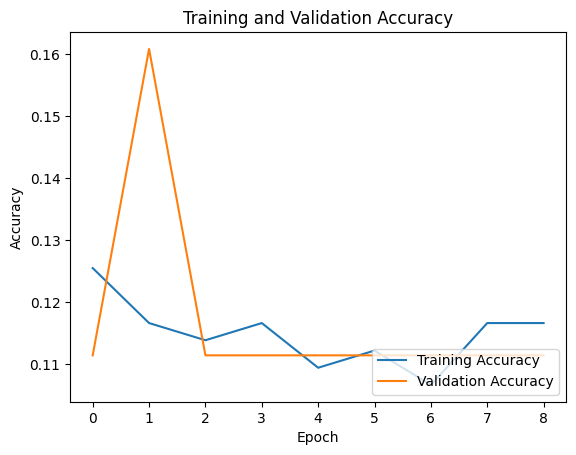

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')
plt.show()

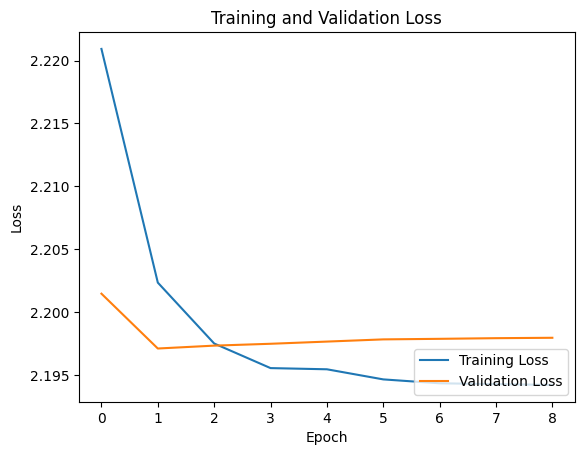

13/13 [==============================] - 14s 998ms/step - loss: 2.1971 - accuracy: 0.1609


In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')  
plt.legend(loc='lower right')
plt.title('Training and Validation Loss')
plt.show()
val_loss, val_acc = model.evaluate(X_val, Y_val)

In [ ]:
model = tf.keras.models.load_model('best_model_effecientnetb0.keras')

test_loss, test_acc = model.evaluate(X_test, Y_test)
print(f"Final Test Accuracy: {test_acc:.2f}")


OSError: No file or directory found at best_model_mobilenetv2.keras

In [ ]:
model.save('final_model.keras')

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

image_path = r"C:\Users\Leonilo Molar\Downloads\sample\dthm001.png"

# Load the image with the same size as the model's input size
img = load_img(image_path, target_size=(150, 150))  # Adjust (224, 224) to your model's input size
img_array = img_to_array(img)  # Convert image to a NumPy array
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array = img_array / 255.0  # Normalize to [0, 1] if your model expects normalized input

print(f"Image shape after preprocessing: {img_array.shape}")
model = tf.keras.models.load_model('final_model.keras')

# Predict the class
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions, axis=1)[0]  # Get the predicted class index
confidence = np.max(predictions)  # Get confidence score

# Print the class name and confidence
print(f"Predicted building name: {classes[predicted_class]}")
print(f"Confidence: {confidence:.2f}")

Image shape after preprocessing: (1, 150, 150, 3)
1/1 [==============================] - 2s 2s/step
Predicted building name: foodtech
Confidence: 0.88


In [ ]:
# ...existing code...
model = tf.keras.models.load_model('final_model.keras')

# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the converted model to file
with open('final_model.tflite', 'wb') as f:
    f.write(tflite_model)
# ...existing code...




INFO:tensorflow:Assets written to: C:\Users\LEONIL~1\AppData\Local\Temp\tmp5hideiul\assets


INFO:tensorflow:Assets written to: C:\Users\LEONIL~1\AppData\Local\Temp\tmp5hideiul\assets
